In [1]:
# Install necessary libraries (if not already installed)
!pip install efficientnet
!pip install albumentations
!pip install torch torchvision tensorflow-model-optimization
!pip install seaborn
!pip install joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 9.3 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageChops, ImageEnhance
from io import BytesIO
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_model_optimization as tfmot
import torch
import torch.nn as nn
import torchvision.models as models_torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import logging
import seaborn as sns
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# np.random.seed(42)
# random.seed(42)
# tf.random.set_seed(42)
# torch.manual_seed(42)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(42)

# # Set up logging
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)


In [5]:
def adaptive_ela(image_path, quality=90):
    """
    Perform Error Level Analysis (ELA) on an image.

    Parameters:
    - image_path: Path to the image file.
    - quality: JPEG quality for resaving the image.

    Returns:
    - ELA image as a NumPy array.
    """
    original = Image.open(image_path).convert('RGB')
    buffer = BytesIO()
    original.save(buffer, 'JPEG', quality=quality)
    buffer.seek(0)
    resaved = Image.open(buffer)
    ela_image = ImageChops.difference(original, resaved)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return np.array(ela_image)


def adaptive_ela_and_resize(path, size=(224, 224)):
    """
    Apply ELA and resize the image.

    Parameters:
    - path: Path to the image file.
    - size: Tuple indicating the desired image size.

    Returns:
    - Preprocessed ELA image as a NumPy array.
    """
    ela_img = adaptive_ela(path)
    ela_img = cv2.resize(ela_img, size)
    return ela_img

def preprocess_images(image_paths):
    """
    Preprocess images using multiprocessing for efficiency.

    Parameters:
    - image_paths: List of image file paths.

    Returns:
    - NumPy array of preprocessed images.
    """
    with Pool() as pool:
        images = pool.map(adaptive_ela_and_resize, image_paths)
    return np.array(images)


In [6]:
# Define dataset paths
real_images_path = '/content/drive/MyDrive/CS570_Deep_Learning/real_and_fake_face/training_real/'
fake_images_path = '/content/drive/MyDrive/CS570_Deep_Learning/real_and_fake_face/training_fake/'

# Get list of image file paths
real_images = [os.path.join(real_images_path, img) for img in os.listdir(real_images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
fake_images = [os.path.join(fake_images_path, img) for img in os.listdir(fake_images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Create labels (0 for real, 1 for fake)
labels = [0] * len(real_images) + [1] * len(fake_images)

# Combine image paths and labels into a DataFrame
data = pd.DataFrame({'image_path': real_images + fake_images, 'label': labels})

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total samples: {len(data)}")
print(f"Real samples: {sum(data['label'] == 0)}")
print(f"Fake samples: {sum(data['label'] == 1)}")


Total samples: 2041
Real samples: 1081
Fake samples: 960


In [7]:
# Preprocess images
print("Starting image preprocessing...")
X = preprocess_images(data['image_path'])
print("Image preprocessing completed.")
print(f"Preprocessed images shape: {X.shape}")

y = np.array(data['label'])
print(f"Labels shape: {y.shape}")


Starting image preprocessing...
Image preprocessing completed.
Preprocessed images shape: (2041, 224, 224, 3)
Labels shape: (2041,)


In [8]:
# Train-Test Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Further split into Training and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)  # 0.1765 * 0.85 ≈ 0.15

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 1427
Validation samples: 307
Test samples: 307


In [9]:
from tensorflow.keras.utils import Sequence
import albumentations as albu

class DataGenerator(Sequence):
    def __init__(self, X, y=None, batch_size=32, dim=(224, 224), n_channels=3, n_classes=1, shuffle=True, augment=False):
        """
        Initialization
        """
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()
        self.augmentor = self.get_augmentor()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X_batch = self.X[batch_indexes]
        if self.y is not None:
            y_batch = self.y[batch_indexes]
            if self.augment:
                X_batch = self.__augment_batch(X_batch)
            return X_batch, y_batch
        else:
            return X_batch

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def get_augmentor(self):
        """
        Define augmentation pipeline
        """
        if self.augment:
            return albu.Compose([
                albu.HorizontalFlip(p=0.5),
                albu.VerticalFlip(p=0.5),
                albu.RandomRotate90(p=0.5),
                albu.ShiftScaleRotate(p=0.5),
                albu.ColorJitter(p=0.5),
                albu.GridDistortion(p=0.2),
                albu.ElasticTransform(p=0.2),
                albu.GaussNoise(p=0.2)
            ])
        else:
            return albu.Compose([])

    def __augment_batch(self, batch):
        """
        Apply augmentation to a batch of images
        """
        augmented_batch = []
        for img in batch:
            augmented = self.augmentor(image=img)['image']
            augmented_batch.append(augmented)
        return np.array(augmented_batch)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [10]:
# Compute class weights to handle class imbalance
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Create data generators
train_generator = DataGenerator(
    X=X_train,
    y=y_train,
    batch_size=32,
    dim=(224, 224),
    n_channels=3,
    n_classes=1,
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    X=X_val,
    y=y_val,
    batch_size=32,
    dim=(224, 224),
    n_channels=3,
    n_classes=1,
    shuffle=False,
    augment=False
)

test_generator = DataGenerator(
    X=X_test,
    y=y_test,
    batch_size=32,
    dim=(224, 224),
    n_channels=3,
    n_classes=1,
    shuffle=False,
    augment=False
)


Class Weights: {0: 0.9450331125827814, 1: 1.0617559523809523}


In [11]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
# )
# datagen.fit(X_train)

In [12]:
def create_efficientnet_model():
    """
    Create and compile the EfficientNetB0 model.

    Returns:
    - Compiled Keras model.
    """
    base_model = EfficientNetV2B0(
        weights='imagenet', include_top=False, input_shape=(224, 224, 3)
    )
    base_model.trainable = True  # Enable fine-tuning

    # Freeze the first 100 layers
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid'),  # Binary classification
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)
    return model

efficientnet_model = create_efficientnet_model()
efficientnet_model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,083,409 (23.21 MB)

 Trainable params: 5,319,745 (20.29 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/CS570_Deep_Learning/best_efficientnet_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the EfficientNet model
# history = efficientnet_model.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     validation_data=(X_val, y_val),
#     epochs=25,
#     callbacks=[early_stopping, lr_reduction, checkpoint],
# )


In [17]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Enable memory growth to avoid allocating all GPU memory upfront
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU(s): {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print("Error setting up GPU:", e)
else:
    print("No GPU detected. Using CPU.")

Error setting up GPU: Physical devices cannot be modified after being initialized


In [18]:
import multiprocessing

max_workers = multiprocessing.cpu_count()

history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, lr_reduction, checkpoint],
    class_weight=class_weights,
)

# Load the best model
efficientnet_model.load_weights('/content/drive/MyDrive/CS570_Deep_Learning/best_efficientnet_model.keras')

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5679 - loss: 0.6755 - val_accuracy: 0.5868 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5816 - loss: 0.6650 - val_accuracy: 0.6181 - val_loss: 0.6593 - learning_rate: 1.0000e-04
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6194 - loss: 0.6588 - val_accuracy: 0.6458 - val_loss: 0.6347 - learning_rate: 1.0000e-04
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6634 - loss: 0.6244 - val_accuracy: 0.6528 - val_loss: 0.6253 - learning_rate: 1.0000e-04
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6521 - loss: 0.6059 - val_accuracy: 0.6597 - val_loss: 0.6165 - learning_rate: 1.0000e-04
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6626 - loss: 0.6052 - val_accuracy: 0.6701 - val_loss: 0.6012 - learning_rate: 1.0000e-04
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6688 - loss:

In [ ]:
# Load the best model
# efficientnet_model.load_weights('/content/drive/MyDrive/CS570_Deep_Learning/best_efficientnet_model.keras')


In [20]:
def prepare_data_for_knn(X_train, X_val, X_test):
    """
    Flatten, standardize, and apply PCA to the data for KNN.

    Parameters:
    - X_train, X_val, X_test: NumPy arrays of preprocessed images.

    Returns:
    - PCA-reduced and standardized training, validation, and test data.
    - Scaler and PCA objects for future use.
    """
    scaler = StandardScaler()
    pca = PCA(n_components=200, random_state=42)  # Adjust components as needed

    # Flatten the images
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Standardize and apply PCA
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_train_pca = pca.fit_transform(X_train_scaled)

    X_val_scaled = scaler.transform(X_val_flat)
    X_val_pca = pca.transform(X_val_scaled)

    X_test_scaled = scaler.transform(X_test_flat)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_val_pca, X_test_pca, scaler, pca

# Apply preprocessing
X_train_pca, X_val_pca, X_test_pca, scaler, pca = prepare_data_for_knn(X_train, X_val, X_test)


In [21]:
# Train KNN with reduced data
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_pca, y_train)


KNeighborsClassifier()

In [22]:
def create_vit_model():
    """
    Create the Vision Transformer (ViT) model.

    Returns:
    - ViT model with modified classification head.
    """
    vit_model = models_torch.vit_b_16(weights='IMAGENET1K_V1')
    # Modify the classification head for binary classification
    vit_model.heads.head = nn.Sequential(
        nn.Linear(vit_model.heads.head.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 1),
    )
    return vit_model

# Prepare datasets for ViT
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Custom dataset for images.

        Parameters:
        - images: NumPy array of images.
        - labels: NumPy array of labels.
        - transform: Transformations to apply.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img_pil = Image.fromarray(img.astype('uint8'), 'RGB')
        if self.transform:
            img = self.transform(img_pil)
        else:
            img = transforms.ToTensor()(img_pil)
        label = self.labels[idx]
        return img, label

# Create PyTorch datasets
train_dataset = ImageDataset(X_train, y_train, transform=vit_transform)
val_dataset = ImageDataset(X_val, y_val, transform=vit_transform)
test_dataset = ImageDataset(X_test, y_test, transform=vit_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the ViT model
vit_model = create_vit_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # Validation phase
    vit_model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = vit_model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    logger.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vit_model.state_dict(), '/content/drive/MyDrive/CS570_Deep_Learning/best_vit_model.pth')

# Load the best ViT model
vit_model.load_state_dict(torch.load('/content/drive/MyDrive/CS570_Deep_Learning/best_vit_model.pth'))
vit_model.eval()


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 170MB/s]
<ipython-input-22-a9e56b35eaf3>:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [27]:
def ensemble_predict_batch(efficientnet_model, vit_model, knn_clf, scaler, pca, X_data, batch_size=32, device='cpu'):
    """
    Perform ensemble predictions using EfficientNet, ViT, and KNN.

    Parameters:
    - efficientnet_model: Trained Keras EfficientNet model.
    - vit_model: Trained PyTorch ViT model.
    - knn_clf: Trained KNN classifier.
    - scaler: Fitted StandardScaler.
    - pca: Fitted PCA transformer.
    - X_data: NumPy array of test images.
    - batch_size: Batch size for processing.
    - device: Device to run ViT model ('cpu' or 'cuda').

    Returns:
    - NumPy array of ensemble predictions.
    """
    final_predictions = []
    vit_model.eval()
    vit_model.to(device)

    # Define transform for ViT (without augmentation)
    vit_transform_eval = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    for i in range(0, len(X_data), batch_size):
        # Process a batch of data
        X_batch = X_data[i:i + batch_size]

        # **Ensure channels-last format**
        if X_batch.shape[-1] != 3:
            X_batch = X_batch.transpose(0, 2, 3, 1)  # From (batch, channels, height, width) to (batch, height, width, channels)

        # EfficientNet predictions
        eff_pred = efficientnet_model.predict(X_batch)
        eff_pred_class = (eff_pred > 0.5).astype(int).flatten()

        # Prepare data for ViT
        X_batch_vit = []
        for img in X_batch:
            img_pil = Image.fromarray(img.astype('uint8'), 'RGB')
            img_vit = vit_transform_eval(img_pil)
            X_batch_vit.append(img_vit)
        X_batch_vit = torch.stack(X_batch_vit).to(device)

        with torch.no_grad():
            vit_pred = vit_model(X_batch_vit)
            vit_pred_probs = torch.sigmoid(vit_pred).cpu().numpy()
        vit_pred_class = (vit_pred_probs > 0.5).astype(int).flatten()

        # Flatten and apply scaler and PCA for KNN
        X_batch_flat = X_batch.reshape(X_batch.shape[0], -1)
        X_batch_scaled = scaler.transform(X_batch_flat)
        X_batch_pca = pca.transform(X_batch_scaled)

        knn_pred = knn_clf.predict_proba(X_batch_pca)[:, 1]
        knn_pred_class = (knn_pred > 0.5).astype(int)

        # Final ensemble prediction: majority voting
        total_pred = eff_pred_class + vit_pred_class + knn_pred_class
        batch_pred = (total_pred >= 2).astype(int)  # Majority vote among 3 models

        final_predictions.extend(batch_pred)

    return np.array(final_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
              precision    recall  f1-score   support

        Real       0.60      0.88      0.72       163
        Fake       0.72      0.34      0.46       144

    accuracy                           0.63       307
   macro avg       0.66      0.61      0.59       307
weighted avg       0.66      0.63      0.60       307

Confusion Matrix:
[[144  19]
 [ 95  49]]


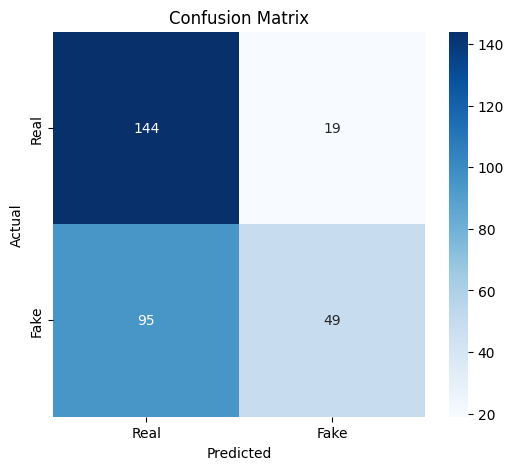

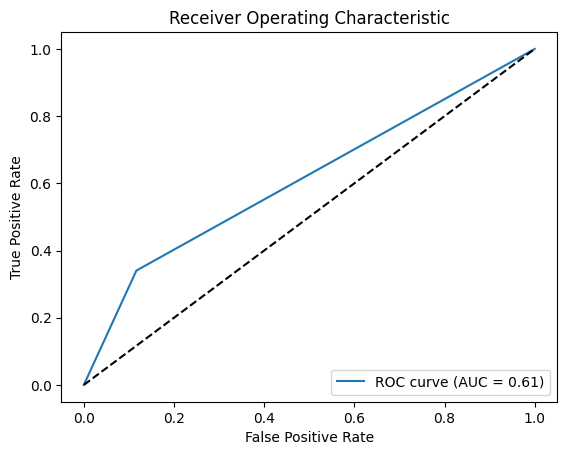

Accuracy: 0.63
Precision: 0.72
Recall: 0.34
F1-Score: 0.46


In [28]:
# Perform ensemble predictions on the test set
final_predictions = ensemble_predict_batch(
    efficientnet_model, vit_model, knn_clf, scaler, pca, X_test, batch_size=32, device=device
)

# Print classification report
print(classification_report(y_test, final_predictions, target_names=['Real', 'Fake']))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC and AUC Metrics
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Additional Performance Metrics
accuracy = np.mean(final_predictions == y_test)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


In [45]:
test_generator.X.shape

(307, 224, 224, 3)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       163
           1       0.64      0.56      0.59       144

    accuracy                           0.64       307
   macro avg       0.64      0.64      0.64       307
weighted avg       0.64      0.64      0.64       307

Confusion Matrix:
[[118  45]
 [ 64  80]]


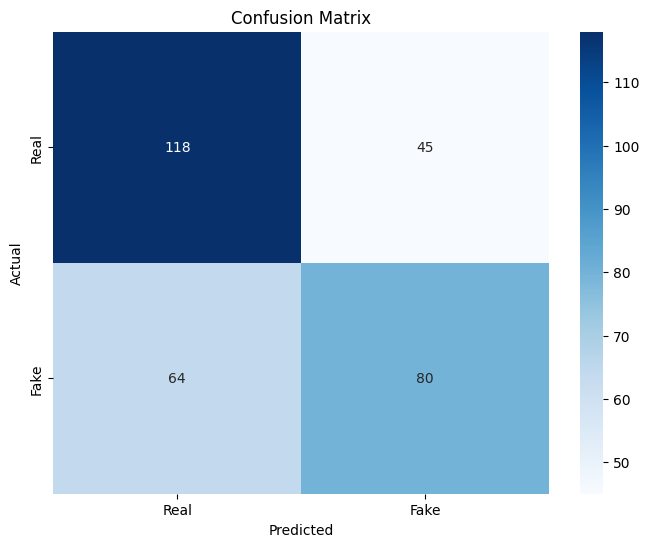

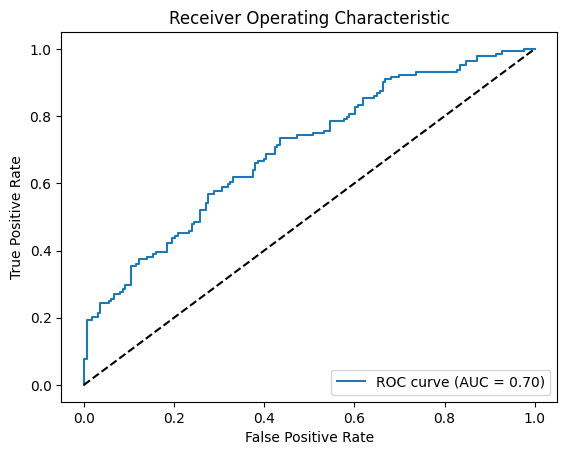

In [49]:
efficientnet_model.load_weights('/content/drive/MyDrive/CS570_Deep_Learning/best_efficientnet_model.keras')

# Evaluate the model
y_pred_probs = efficientnet_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
# y_test = ['label'].values

# y_test_from_generator = []
# for _, labels in test_generator:
#     y_test_from_generator.extend(labels)
# y_test_from_generator = np.array(y_test_from_generator)

# Now use the labels from the generator in the classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC and AUC Metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

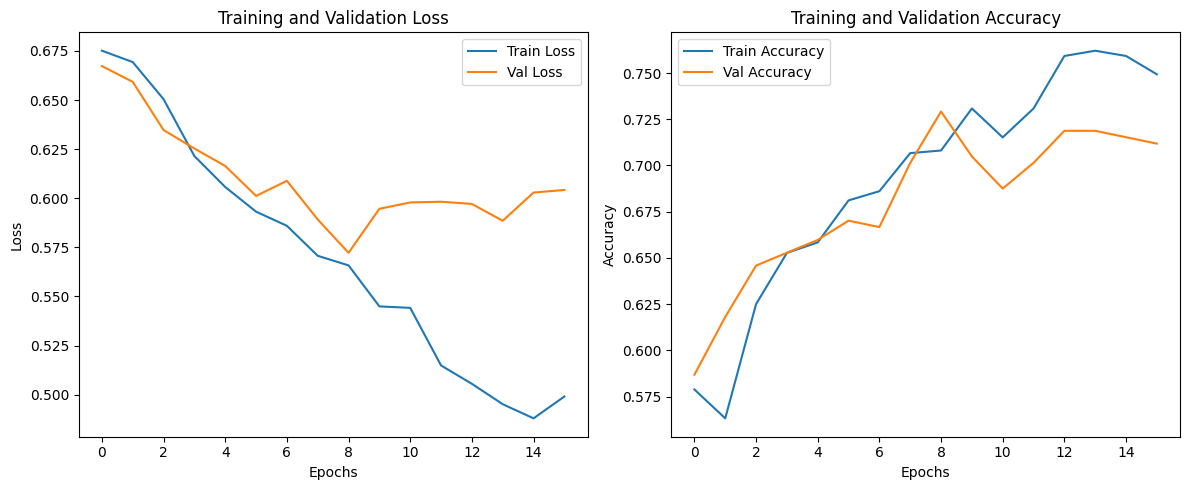

In [51]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.

    Parameters:
    - history: History object from initial training.
    - history_fine: History object from fine-tuning (optional).
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [52]:
# Save EfficientNet model
efficientnet_model.save('/content/drive/MyDrive/CS570_Deep_Learning/final_efficientnet_model.keras')

# Save ViT model
torch.save(vit_model.state_dict(), '/content/drive/MyDrive/CS570_Deep_Learning/final_vit_model.pth')

# Save KNN model and preprocessing objects
joblib.dump(knn_clf, '/content/drive/MyDrive/CS570_Deep_Learning/knn_model.joblib')
joblib.dump(scaler, '/content/drive/MyDrive/CS570_Deep_Learning/scaler.joblib')
joblib.dump(pca, '/content/drive/MyDrive/CS570_Deep_Learning/pca.joblib')

print("All models and preprocessing objects have been saved.")


All models and preprocessing objects have been saved.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


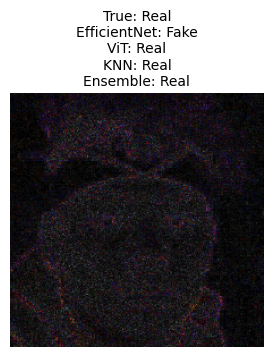

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


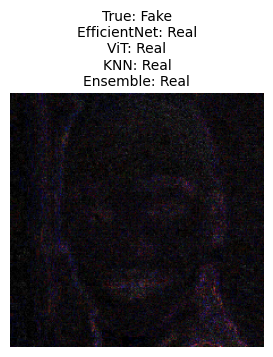

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


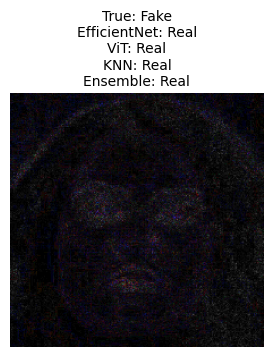

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


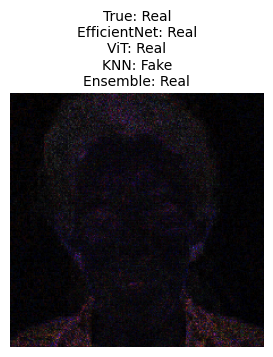

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


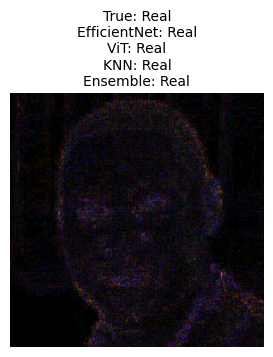

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


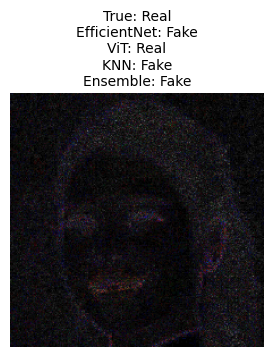

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


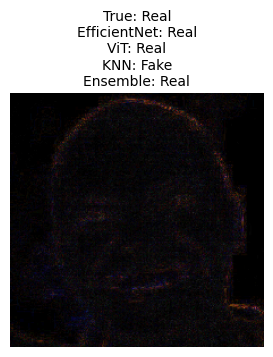

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


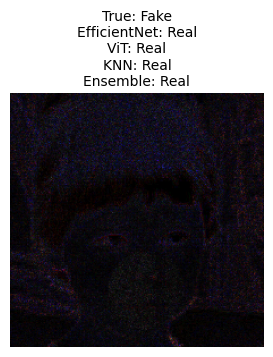

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


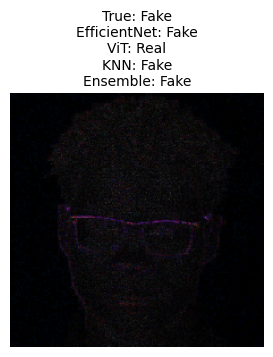

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


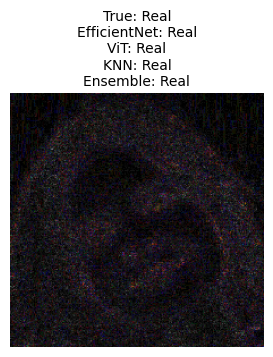

In [78]:
def plot_sample_predictions(efficientnet_model, vit_model, knn_clf, scaler, pca, X_data, y_true, num_samples=5):
    """
    Plot sample images with their true and predicted labels from each model and the ensemble.

    Parameters:
    - efficientnet_model: Trained Keras EfficientNet model.
    - vit_model: Trained PyTorch ViT model.
    - knn_clf: Trained KNN classifier.
    - scaler: Fitted StandardScaler.
    - pca: Fitted PCA transformer.
    - X_data: NumPy array of test images.
    - y_true: True labels corresponding to X_data.
    - num_samples: Number of samples to plot.
    """
    indices = np.random.choice(len(X_data), num_samples, replace=False)
    vit_model.eval()
    vit_model.to(device)

    # Define transform for ViT (without augmentation)
    vit_transform_eval = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    for idx in indices:
        img = X_data[idx]
        true_label = 'Fake' if y_true[idx] == 1 else 'Real'

        # EfficientNet prediction
        eff_pred_prob = efficientnet_model.predict(np.expand_dims(img, axis=0))[0][0]
        eff_pred_class = 'Fake' if eff_pred_prob > 0.5 else 'Real'

        # ViT prediction
        img_pil = Image.fromarray(img.astype('uint8'), 'RGB')
        img_vit = vit_transform_eval(img_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            vit_output = vit_model(img_vit)
            vit_pred_prob = torch.sigmoid(vit_output).cpu().item()
        vit_pred_class = 'Fake' if vit_pred_prob > 0.5 else 'Real'

        # KNN prediction
        img_flat = img.reshape(1, -1)
        img_scaled = scaler.transform(img_flat)
        img_pca = pca.transform(img_scaled)
        knn_pred_prob = knn_clf.predict_proba(img_pca)[0, 1]
        knn_pred_class = 'Fake' if knn_pred_prob > 0.5 else 'Real'

        # Ensemble prediction: Majority voting
        total_votes = sum([
            eff_pred_prob > 0.5,
            vit_pred_prob > 0.5,
            knn_pred_prob > 0.5
        ])
        ensemble_pred_class = 'Fake' if total_votes >= 2 else 'Real'

        # Plot image and predictions
        plt.figure(figsize=(4, 4))
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        plt.title(
            f"True: {true_label}\n"
            f"EfficientNet: {eff_pred_class}\n"
            f"ViT: {vit_pred_class}\n"
            f"KNN: {knn_pred_class}\n"
            f"Ensemble: {ensemble_pred_class}",
            fontsize=10
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage
plot_sample_predictions(efficientnet_model, vit_model, knn_clf, scaler, pca, X_test, y_test, num_samples=10)


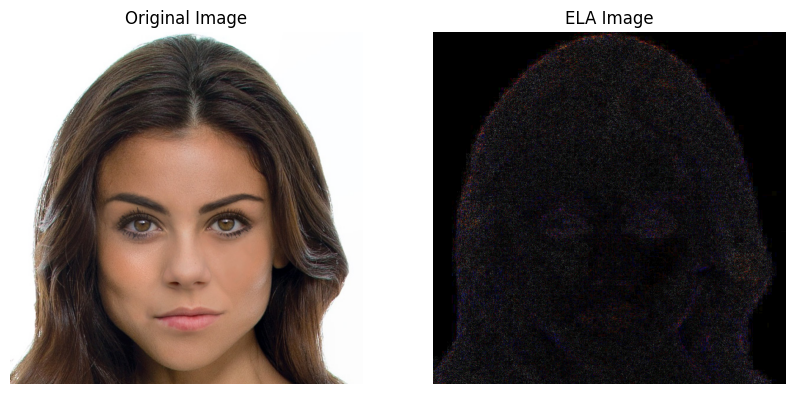

In [54]:
def plot_ela_image(image_path, quality=90):
    """
    Plot the original and ELA images side by side.

    Parameters:
    - image_path: Path to the image file.
    - quality: JPEG quality for ELA.
    """
    original = Image.open(image_path).convert('RGB')
    buffer = BytesIO()
    original.save(buffer, 'JPEG', quality=quality)
    buffer.seek(0)
    resaved = Image.open(buffer)
    ela_image = ImageChops.difference(original, resaved)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(ela_image)
    axs[1].set_title('ELA Image')
    axs[1].axis('off')
    plt.show()

# Example usage
sample_image_path = data['image_path'].iloc[10]
plot_ela_image(sample_image_path)


In [ ]:
# # Save EfficientNet model
# efficientnet_model.save('/content/drive/MyDrive/CS570_Deep_Learning/final_efficientnet_model.keras')

# # Save ViT model
# torch.save(vit_model.state_dict(), '/content/drive/MyDrive/CS570_Deep_Learning/final_vit_model.pth')

# # Save KNN model and preprocessing objects
# joblib.dump(knn_clf, '/content/drive/MyDrive/CS570_Deep_Learning/knn_model.joblib')
# joblib.dump(scaler, '/content/drive/MyDrive/CS570_Deep_Learning/scaler.joblib')
# joblib.dump(pca, '/content/drive/MyDrive/CS570_Deep_Learning/pca.joblib')

# print("All models and preprocessing objects have been saved successfully.")
